2025-09-29 11:20:43.206 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-29 11:20:43.207 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-29 11:20:43.523 
  command:

    streamlit run C:\Users\user\anaconda3\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
2025-09-29 11:20:43.524 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-29 11:20:43.525 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-29 11:20:43.526 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-29 11:20:43.527 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when runni

DeltaGenerator(_form_data=FormData(form_id='input_form'))

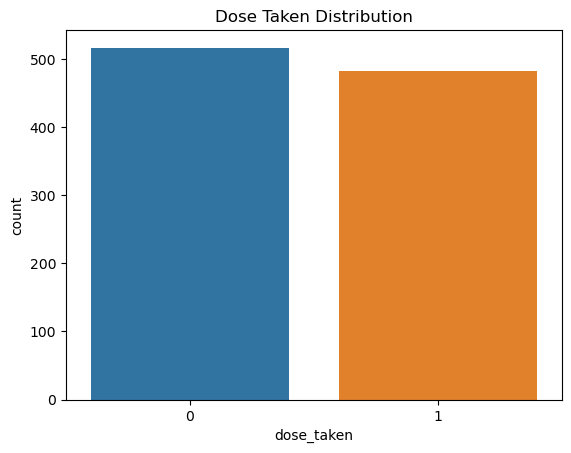

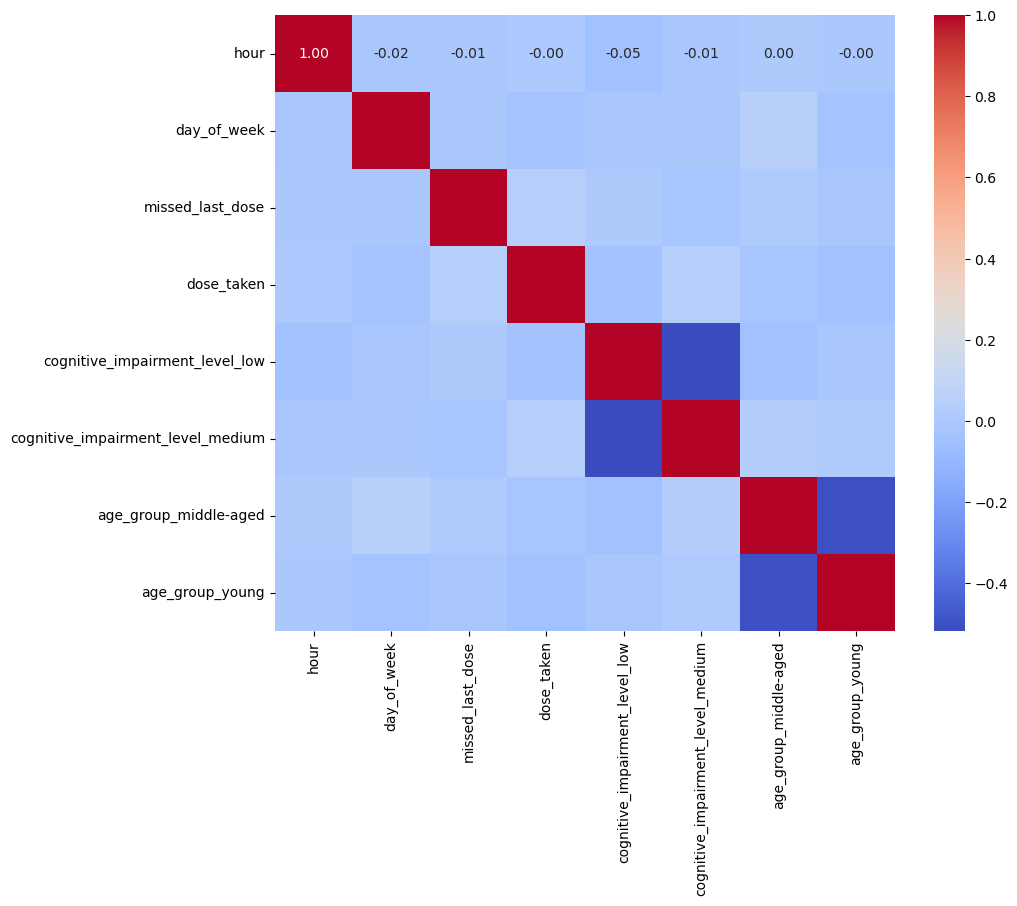

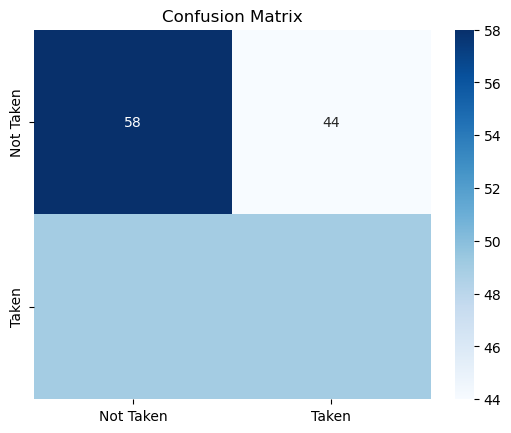

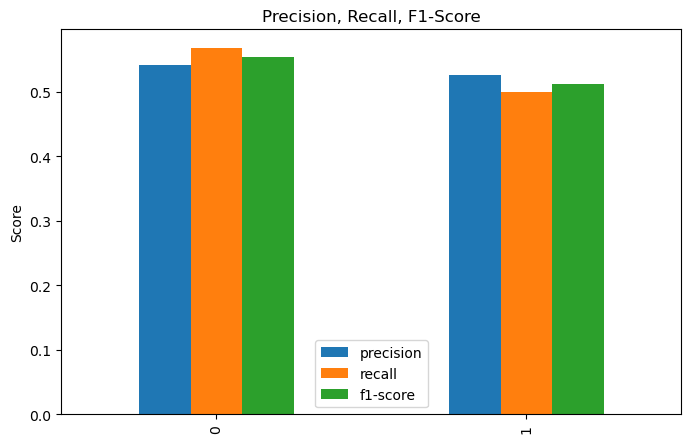

In [1]:
# ===================================
# Import required libraries
# ===================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import streamlit as st

# ===================================
# Simulate the Dataset
# ===================================
np.random.seed(42)
insurance = pd.DataFrame({
    'hour': np.random.randint(6, 22, 1000),
    'day_of_week': np.random.randint(0, 7, 1000),
    'missed_last_dose': np.random.randint(0, 2, 1000),
    'cognitive_impairment_level': np.random.choice(['low', 'medium', 'high'], 1000),
    'age_group': np.random.choice(['young', 'middle-aged', 'elderly'], 1000),
    'dose_taken': np.random.randint(0, 2, 1000)
})

# ===================================
# Feature Engineering
# ===================================
insurance_encoded = pd.get_dummies(insurance, columns=['cognitive_impairment_level', 'age_group'], drop_first=True)

X = insurance_encoded.drop('dose_taken', axis=1)
y = insurance_encoded['dose_taken']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ===================================
# Model Training
# ===================================
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Save model
model_filename = 'smart_pill_model.sav'
joblib.dump(model, model_filename)
model_filename = 'smart_pill_model.joblib'
# ===================================
# Streamlit App UI
# ===================================

st.set_page_config(page_title="Smart Pill Dispensary", layout="centered")
st.title("💊 Smart Pill Dispensary Prediction App")
st.markdown("This app predicts whether a patient will take their dose based on input features.")

# Input Form
with st.form("input_form"):
    st.subheader("Enter Patient Information")

    hour = st.slider("Hour of Day (6-21)", 6, 21, 12)
    day_of_week = st.selectbox("Day of Week", ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'])
    missed_last_dose = st.radio("Missed Last Dose?", ['No', 'Yes'])
    cognitive_impairment_level = st.selectbox("Cognitive Impairment Level", ['low', 'medium', 'high'])
    age_group = st.selectbox("Age Group", ['young', 'middle-aged', 'elderly'])

    submitted = st.form_submit_button("Predict")

# Map input to correct format
day_map = {'Sunday':0, 'Monday':1, 'Tuesday':2, 'Wednesday':3, 'Thursday':4, 'Friday':5, 'Saturday':6}
missed_map = {'No': 0, 'Yes': 1}

input_dict = {
    'hour': hour,
    'day_of_week': day_map[day_of_week],
    'missed_last_dose': missed_map[missed_last_dose],
    'cognitive_impairment_level': cognitive_impairment_level,
    'age_group': age_group
}

# Predict
if submitted:
    input_df = pd.DataFrame([input_dict])
    input_df = pd.get_dummies(input_df)

    # Ensure columns match training data
    model_columns = X.columns
    for col in model_columns:
        if col not in input_df.columns:
            input_df[col] = 0
    input_df = input_df[model_columns]

    loaded_model = joblib.load(model_filename)
    prediction = loaded_model.predict(input_df)[0]

    st.success(f"Prediction: {'Dose Will Be Taken' if prediction == 1 else 'Dose Will NOT Be Taken'}")

# ===================================
# EDA Section
# ===================================
st.subheader("📊 Exploratory Data Analysis (EDA)")

st.markdown("**1. Dose Taken Distribution**")
fig1, ax1 = plt.subplots()
sns.countplot(data=insurance, x='dose_taken', ax=ax1)
ax1.set_title("Dose Taken Distribution")
st.pyplot(fig1)

st.markdown("**2. Feature Correlation Heatmap**")
temp_df = pd.get_dummies(insurance, columns=['cognitive_impairment_level', 'age_group'], drop_first=True)
fig2, ax2 = plt.subplots(figsize=(10, 8))
sns.heatmap(temp_df.corr(), annot=True, fmt=".2f", cmap="coolwarm", ax=ax2)
st.pyplot(fig2)

# ===================================
# Model Evaluation
# ===================================
st.subheader("📈 Model Evaluation")

y_pred = model.predict(X_test)

st.markdown(f"**Accuracy:** {accuracy_score(y_test, y_pred):.2f}")

st.markdown("**Classification Report:**")
report_df = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).transpose()
st.dataframe(report_df)

conf_matrix = confusion_matrix(y_test, y_pred)
fig3, ax3 = plt.subplots()
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Taken", "Taken"], yticklabels=["Not Taken", "Taken"], ax=ax3)
ax3.set_title("Confusion Matrix")
st.pyplot(fig3)

# Precision, Recall, F1-Score Bar Plot
metrics_df = report_df.iloc[:2][['precision', 'recall', 'f1-score']]
fig4, ax4 = plt.subplots(figsize=(8, 5))
metrics_df.plot(kind='bar', ax=ax4)
ax4.set_title("Precision, Recall, F1-Score")
ax4.set_ylabel("Score")
st.pyplot(fig4)

